<a href="https://colab.research.google.com/github/TawadrosGamal/Ecommearce-Forecasts/blob/main/sales_inv_forcast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install mysql-connector

     |████████████████████████████████| 11.9 MB 7.2 MB/s 
  Created wheel for mysql-connector: filename=mysql_connector-2.2.9-cp37-cp37m-linux_x86_64.whl size=247965 sha256=31520f7343c2f6300b0281fcf363f877ce7fa697af1425e8241a2bb539108612
  Stored in directory: /root/.cache/pip/wheels/42/2f/c3/692fc7fc1f0d8c06b9175d94f0fc30f4f92348f5df5af1b8b7
Successfully built mysql-connector


In [ ]:
import mysql.connector

def fetch_table_data(table_name):
    # The connect() constructor creates a connection to the MySQL server and returns a MySQLConnection object.
    cnx = mysql.connector.connect(
        host="120.79.99.107",
        port="3306",
        user="test",
        password="up2china",
        database="accountadmin"
    )

    cursor = cnx.cursor()
    cursor.execute('select * from ' + table_name)

    header = [row[0] for row in cursor.description]

    rows = cursor.fetchall()

    # Closing connection
    cnx.close()

    return header, rows


def export(table_name):
    header, rows = fetch_table_data(table_name)

    # Create csv file
    f = open(table_name + '.csv', 'w', encoding="utf-8")

    # Write header
    f.write(','.join(header) + '\n')

    for row in rows:
        f.write(','.join(str(r) for r in row) + '\n')

    f.close()
    print(str(len(rows)) + ' rows written successfully to ' + f.name)


# Tables to be exported
#export('crm_store_salesflow')
export('mlog')
#190134 rows written successfully to crm_store_salesflow.csv
#203970 rows written successfully to mlog.csv

422899 rows written successfully to mlog.csv


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import matplotlib.font_manager
from sklearn import metrics
pd.options.mode.chained_assignment = None  # default='warn'

plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

# matplotlib.use("pgf")
# pgf_with_custom_preamble = {
#     # "font.size": 18,
#     "pgf.rcfonts": False,
#     "text.usetex": True,
#     "pgf.preamble": [
#         # math setup:
#         r"\usepackage{unicode-math}",

#         # fonts setup:
#         r"\setmainfont{WenQuanYi Zen Hei}",
#         r"\setsansfont{WenQuanYi Zen Hei}",
#         r"\setmonofont{WenQuanYi Zen Hei Mono}",
#     ],
# }
# matplotlib.rcParams.update(pgf_with_custom_preamble)

%matplotlib inline

In [ ]:
#df_sales = pd.read_csv("crm_store_salesflow.csv", error_bad_lines=False, encoding="utf-8-sig")
df_mlog = pd.read_csv("mlog.csv", error_bad_lines=False, encoding="utf-8-sig")

b'Skipping line 7: expected 19 fields, saw 22\nSkipping line 10: expected 19 fields, saw 22\nSkipping line 12: expected 19 fields, saw 22\nSkipping line 14: expected 19 fields, saw 22\nSkipping line 18: expected 19 fields, saw 22\nSkipping line 19: expected 19 fields, saw 22\nSkipping line 20: expected 19 fields, saw 22\nSkipping line 21: expected 19 fields, saw 22\nSkipping line 24: expected 19 fields, saw 22\nSkipping line 27: expected 19 fields, saw 22\nSkipping line 30: expected 19 fields, saw 22\nSkipping line 31: expected 19 fields, saw 22\nSkipping line 32: expected 19 fields, saw 22\nSkipping line 35: expected 19 fields, saw 22\nSkipping line 36: expected 19 fields, saw 22\nSkipping line 40: expected 19 fields, saw 22\nSkipping line 44: expected 19 fields, saw 22\nSkipping line 47: expected 19 fields, saw 22\nSkipping line 48: expected 19 fields, saw 22\nSkipping line 53: expected 19 fields, saw 22\nSkipping line 57: expected 19 fields, saw 22\nSkipping line 61: expected 19 fie

### Sales Cleaning

In [ ]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190134 entries, 0 to 190133
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   id              190134 non-null  int64 
 1   lb_no           190134 non-null  object
 2   lp_no           128024 non-null  object
 3   item_code       190134 non-null  int64 
 4   item_title      190134 non-null  object
 5   warehouse       190134 non-null  object
 6   delivery_time   190134 non-null  object
 7   type            190134 non-null  object
 8   inventory_type  190134 non-null  object
 9   quantity        190134 non-null  int64 
 10  total_quantity  190134 non-null  int64 
 11  erp_no          190134 non-null  int64 
 12  outside_no      190134 non-null  int64 
 13  customer        190134 non-null  int64 
dtypes: int64(7), object(7)
memory usage: 20.3+ MB


In [ ]:
df_sales.describe()

id     item_code  ...    outside_no  customer
count  190134.000000  1.901340e+05  ...  1.901340e+05  190134.0
mean   130697.870623  6.194608e+11  ...  1.630753e+18      82.0
std     75261.132353  3.802191e+11  ...  3.845530e+17       0.0
min         1.000000  6.116356e+11  ...  5.942199e+17      82.0
25%     47534.250000  6.120664e+11  ...  1.286829e+18      82.0
50%    146627.500000  6.121904e+11  ...  1.603959e+18      82.0
75%    194160.750000  6.123133e+11  ...  1.996490e+18      82.0
max    241694.000000  6.118306e+13  ...  2.360113e+18      82.0

[8 rows x 7 columns]

In [ ]:
df_sales.head()

id                lb_no  ...           outside_no  customer
0   1  LBX0323267097496017  ...  1912304341951735013        82
1   2  LBX0323267102461943  ...  1913838481917617059        82
2   3  LBX0323267103398294  ...  1912749086641830956        82
3   4  LBX0323267103323808  ...  1912804058179310901        82
4   5  LBX0323267103304701  ...  1911391704636237438        82

[5 rows x 14 columns]

In [ ]:
df_sales["warehouse"].value_counts()

菜鸟杭州保税2号仓    190134
Name: warehouse, dtype: int64

In [ ]:
df_sales["customer"].value_counts()

82    190134
Name: customer, dtype: int64

In [ ]:
df_sales["type"].value_counts()

交易出库    190134
Name: type, dtype: int64

In [ ]:
df_sales["inventory_type"].value_counts()

可销售库存    190134
Name: inventory_type, dtype: int64

In [ ]:
df_sales_clean = df_sales[["item_title", "item_code",  "total_quantity","delivery_time"]]

In [ ]:
df_sales_clean["delivery_time"] = pd.to_datetime(df_sales_clean["delivery_time"])

In [ ]:
df_sales_clean['day'] = df_sales_clean["delivery_time"].dt.day
df_sales_clean['month'] = df_sales_clean["delivery_time"].dt.month
df_sales_clean['year'] = df_sales_clean["delivery_time"].dt.year

In [ ]:
df_sales_clean.head()

item_title     item_code  total_quantity  ... day  month  year
0         女士复合维生素软糖60粒  624879029874             165  ...  30      6  2021
1  vitabiotics 益生菌250亿  622983431253              72  ...  30      6  2021
2     Ultra Calcium 补钙  625497803721            6329  ...  30      6  2021
3         男士复合维生素软糖60粒  625455155425            1606  ...  30      6  2021
4     Ultra Calcium 补钙  625497803721            6332  ...  30      6  2021

[5 rows x 7 columns]

In [ ]:
df_sales_clean.query("quantity>0")

In [ ]:
df_sales_clean.query("total_quantity<0")

Empty DataFrame
Columns: [item_title, item_code, total_quantity, delivery_time, day, month, year]
Index: []

In [ ]:
df_sales_clean.year.value_counts()

2021    132954
2020     57180
Name: year, dtype: int64

In [ ]:
df_sales_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190134 entries, 0 to 190133
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   item_title      190134 non-null  object        
 1   item_code       190134 non-null  int64         
 2   total_quantity  190134 non-null  int64         
 3   delivery_time   190134 non-null  datetime64[ns]
 4   day             190134 non-null  int64         
 5   month           190134 non-null  int64         
 6   year            190134 non-null  int64         
dtypes: datetime64[ns](1), int64(5), object(1)
memory usage: 10.2+ MB


In [ ]:
df_sales_clean.to_csv("sales_data_cleaned.csv")

### MLOG Cleaning

In [ ]:
df_mlog.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 352962 entries, 0 to 352961
Data columns (total 19 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Id          352962 non-null  object 
 1   customer    352200 non-null  float64
 2   sType       352200 non-null  object 
 3   sku_id      233208 non-null  object 
 4   sNum        352200 non-null  float64
 5   sMoney      352200 non-null  float64
 6   iMoney      352200 non-null  float64
 7   orderMoney  352200 non-null  float64
 8   mNom        352200 non-null  object 
 9   mDate       352200 non-null  object 
 10  mNow        352200 non-null  float64
 11  pay_time    352200 non-null  object 
 12  eDate       352200 non-null  object 
 13  sales       352200 non-null  float64
 14  sales_d     352200 non-null  float64
 15  mPhone      352200 non-null  float64
 16  mProvince   349182 non-null  object 
 17  mAddName    352200 non-null  object 
 18  mAdd        351797 non-null  object 
dtypes:

In [ ]:

df_mlog.describe()

customer           sNum         sMoney         iMoney  \
count  352200.000000  352200.000000  352200.000000  352200.000000   
mean       88.184472       1.291252     134.233735      35.561879   
std        20.487101       0.942753     278.461766     205.160875   
min         1.000000      -1.000000  -25999.000000   -3633.750000   
25%        82.000000       1.000000      38.970000       0.000000   
50%        82.000000       1.000000      69.000000       4.140000   
75%       113.000000       1.000000     149.000000       8.730000   
max       132.000000     100.000000   29925.000000    5490.600000   

          orderMoney           mNow          sales        sales_d  \
count  352200.000000  352200.000000  352200.000000  352200.000000   
mean      130.213540      12.900673       8.000219       0.018356   
std       283.189367       0.341176       0.014784       0.139627   
min    -25999.000000      11.000000       8.000000       0.000000   
25%        38.960000      13.000000       8.000000       0.000000   
50%        69.000000      13.000000       8.000000       0.000000   
75%       149.000000      13.000000       8.000000       0.000000   
max     29925.000000      15.000000       9.000000       2.000000   

              mPhone  
count  352200.000000  
mean   131831.150236  
std     83362.958375  
min         1.000000  
25%     58627.750000  
50%    121318.000000  
75%    203548.250000  
max    289964.000000

In [ ]:
print(df_mlog.sMoney.max())
df_mlog.head()

29925.0


Id  customer sType sku_id  sNum  sMoney   iMoney  orderMoney  \
0  9386       1.0     4   None   3.0  1916.0  2091.52      1916.0   
1  9387       1.0     4   None   1.0   648.0     0.00       648.0   
2  9388       1.0     4   None   1.0   648.0   707.36       648.0   
3  9389       1.0     4   None   3.0  1816.0  1982.36      1816.0   
4  9390       1.0     4   None   1.0   648.0   707.36       648.0   

                 mNom       mDate  mNow pay_time                eDate  sales  \
0  607434690428740940  2019-09-03  13.0     None  2019-09-16 12:36:01    8.0   
1  556621710841440705  2019-09-03  12.0     None  2018-01-01 00:00:00    8.0   
2  553481286625957996  2019-09-03  13.0     None  2019-09-10 12:06:00    8.0   
3  607196193936373879  2019-09-03  13.0     None  2019-09-26 12:06:00    8.0   
4  607186657360294387  2019-09-03  13.0     None  2019-09-26 12:06:00    8.0   

   sales_d  mPhone mProvince mAddName  \
0      0.0     1.0       广东省      *小姐   
1      0.0     2.0       福建省      *沪婷   
2      0.0     3.0        上海       *灏   
3      0.0     4.0       四川省      *大伟   
4      0.0     5.0       浙江省      *晓觉   

                                                mAdd  
0         广东省 深圳市 南山区 蛇口街道深圳市南山区三湘海尚南区商铺C055(000000)  
1                福建省 漳州市 芗城区 南坑街道武夷名仕园12-306(363000)  
2             上海 上海市 普陀区 长征镇上海市香樟路57弄13号402室(000000)  
3  四川省 成都市 都江堰市 青城山镇青城镇白鹤路3号 假日青城75-2 王大伟 1355035...  
4        浙江省 杭州市 临安区 昌化镇双塔村工业园区 杭州华通精工器件有限公司(311321)

In [ ]:
df_mlog.sType.value_counts()

612066370828.0    35061
622864660772      15780
532906276104.0    13453
612066370828      13338
532859638188.0    12588
                  ...  
601061131228.0        1
582.0                 1
627423972433          1
656329147446          1
664379280664          1
Name: sType, Length: 960, dtype: int64

In [ ]:
df_mlog.head()

Id  customer sType sku_id  sNum  sMoney   iMoney  orderMoney  \
0  9386       1.0   4.0   None   3.0  1916.0  2091.52      1916.0   
1  9387       1.0   4.0   None   1.0   648.0     0.00       648.0   
2  9388       1.0   4.0   None   1.0   648.0   707.36       648.0   
3  9389       1.0   4.0   None   3.0  1816.0  1982.36      1816.0   
4  9390       1.0   4.0   None   1.0   648.0   707.36       648.0   

                 mNom       mDate  mNow pay_time                eDate  sales  \
0  607434690428740940  2019-09-03  13.0     None  2019-09-16 12:36:01    8.0   
1  556621710841440705  2019-09-03  12.0     None  2018-01-01 00:00:00    8.0   
2  553481286625957996  2019-09-03  13.0     None  2019-09-10 12:06:00    8.0   
3  607196193936373879  2019-09-03  13.0     None  2019-09-26 12:06:00    8.0   
4  607186657360294387  2019-09-03  13.0     None  2019-09-26 12:06:00    8.0   

   sales_d  mPhone mProvince mAddName  \
0      0.0     1.0       广东省      *小姐   
1      0.0     2.0       福建省      *沪婷   
2      0.0     3.0        上海       *灏   
3      0.0     4.0       四川省      *大伟   
4      0.0     5.0       浙江省      *晓觉   

                                                mAdd  
0         广东省 深圳市 南山区 蛇口街道深圳市南山区三湘海尚南区商铺C055(000000)  
1                福建省 漳州市 芗城区 南坑街道武夷名仕园12-306(363000)  
2             上海 上海市 普陀区 长征镇上海市香樟路57弄13号402室(000000)  
3  四川省 成都市 都江堰市 青城山镇青城镇白鹤路3号 假日青城75-2 王大伟 1355035...  
4        浙江省 杭州市 临安区 昌化镇双塔村工业园区 杭州华通精工器件有限公司(311321)

In [ ]:
df_mlog['sales'].value_counts()

8.0    352123
9.0        77
Name: sales, dtype: int64

In [ ]:
df_mlog.query('sMoney <0').shape

(20, 19)

In [ ]:
df_mlog.query('orderMoney <0').shape

(6350, 19)

In [ ]:
df_mlog['sku_id'].value_counts()

4693452979420    25371
None             24990
4482831429253    11206
4478515656606     8239
4425956185226     8215
                 ...  
4472643478090        1
4567518715957        1
4567518715940        1
4537985854014        1
4962402726064        1
Name: sku_id, Length: 760, dtype: int64

In [ ]:
df_mlog['customer'].value_counts()

82.0     187595
113.0     80040
85.0      35530
66.0      22252
121.0     11631
1.0        8374
91.0       2774
120.0      2597
116.0      1233
132.0       126
65.0         48
Name: customer, dtype: int64

In [ ]:

#df_mlog_clean = df_mlog[["customer","sNum", "sMoney", "orderMoney", "mDate", "mProvince"]]
#df_mlog_clean = df_mlog[["sType",'mProvince','mDate','sMoney']]
df_mlog_clean = df_mlog[["customer",'mProvince','mDate','sMoney']]


In [ ]:
df_mlog_clean["mDate"] = pd.to_datetime(df_mlog_clean["mDate"])

In [ ]:
df_mlog_clean['day'] = df_mlog_clean["mDate"].dt.day
df_mlog_clean['month'] = df_mlog_clean["mDate"].dt.month
df_mlog_clean['year'] = df_mlog_clean["mDate"].dt.year

In [ ]:
df_mlog_clean.dropna(inplace = True)

In [ ]:
df_mlog_clean.head()

customer mProvince      mDate  sMoney  day  month    year
0       1.0       广东省 2019-09-03  1916.0  3.0    9.0  2019.0
1       1.0       福建省 2019-09-03   648.0  3.0    9.0  2019.0
2       1.0        上海 2019-09-03   648.0  3.0    9.0  2019.0
3       1.0       四川省 2019-09-03  1816.0  3.0    9.0  2019.0
4       1.0       浙江省 2019-09-03   648.0  3.0    9.0  2019.0

In [ ]:
df_mlog_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 349182 entries, 0 to 352961
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   customer   349182 non-null  float64       
 1   mProvince  349182 non-null  object        
 2   mDate      349182 non-null  datetime64[ns]
 3   sMoney     349182 non-null  float64       
 4   day        349182 non-null  float64       
 5   month      349182 non-null  float64       
 6   year       349182 non-null  float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 21.3+ MB


In [ ]:
for state in df_mlog_clean.mProvince.value_counts().to_frame().index:
  if state=="None":
    print(state)

In [ ]:
df_mlog_clean.query("mProvince == '青海省'").sType.value_counts()
#df_mlog_clean.customer.value_counts().to_frame().index

In [ ]:
total_sales=[]
months=[]
customers=[]
states=[]
data=df_mlog_clean.copy()
for cu in df_mlog_clean.customer.value_counts().to_frame().index:
  for mon in df_mlog_clean.month.value_counts().to_frame().index:
    for state in df_mlog_clean.mProvince.value_counts().to_frame().index:
      customers.append(cu)
      months.append(mon)
      states.append(state)
      total_sales.append(data.query("month == {0} and customer == {1} and mProvince == '{2}'".format(mon,cu,state))['sMoney'].sum())
      
print(len(total_sales))
data_for_model=pd.DataFrame({"cusomter":customers,"month":months,"state":states,"total_sales":total_sales})

data_for_model["day"]=int(1)
data_for_model['day']=data_for_model['day'].astype(int)
data_for_model['month']=data_for_model['month'].astype(int)
#data_for_model['year']=data_for_model['year'].astype(int)
data_for_model['day']=data_for_model['day'].astype(str)
data_for_model['month']=data_for_model['month'].astype(str)
#data_for_model['year']=data_for_model['year'].astype(str)
''' import datetime
data_for_model['Date']=data_for_model['month']+"-"+data_for_model['day']+"-"+data_for_model['year']
data_for_model['Date']=pd.to_datetime(data_for_model["Date"])
data_for_model.sort_values(by=['Date'], inplace=True, ascending=False) '''
data_for_model.total_sales.describe()
data_for_model.head()

3720


cusomter month state  total_sales day
0      82.0     8   广东省    148426.55   1
1      82.0     8   浙江省    102214.40   1
2      82.0     8   江苏省     91467.08   1
3      82.0     8    上海    112356.13   1
4      82.0     8   山东省     87788.31   1

In [ ]:
data_for_model.query("total_sales == 0 and month =='11'")

cusomter month     state  total_sales day
1921       1.0    11     西藏自治区          0.0   1
2292      91.0    11       青海省          0.0   1
2293      91.0    11     西藏自治区          0.0   1
2650     116.0    11      黑龙江省          0.0   1
2658     116.0    11    内蒙古自治区          0.0   1
2663     116.0    11   宁夏回族自治区          0.0   1
2664     116.0    11       青海省          0.0   1
2665     116.0    11     西藏自治区          0.0   1
3017     132.0    11       湖北省          0.0   1
3019     132.0    11       湖南省          0.0   1
3021     132.0    11       陕西省          0.0   1
3023     132.0    11   广西壮族自治区          0.0   1
3025     132.0    11       江西省          0.0   1
3027     132.0    11       山西省          0.0   1
3032     132.0    11       贵州省          0.0   1
3033     132.0    11       甘肃省          0.0   1
3035     132.0    11   宁夏回族自治区          0.0   1
3036     132.0    11       青海省          0.0   1
3037     132.0    11     西藏自治区          0.0   1
3379      65.0    11       广东省          0.0   1
3380      65.0    11       浙江省          0.0   1
3381      65.0    11       江苏省          0.0   1
3382      65.0    11        上海          0.0   1
3383      65.0    11       山东省          0.0   1
3384      65.0    11        北京          0.0   1
3385      65.0    11       四川省          0.0   1
3386      65.0    11       河南省          0.0   1
3387      65.0    11       福建省          0.0   1
3388      65.0    11       辽宁省          0.0   1
3389      65.0    11       湖北省          0.0   1
3390      65.0    11       河北省          0.0   1
3391      65.0    11       湖南省          0.0   1
3392      65.0    11       安徽省          0.0   1
3393      65.0    11       陕西省          0.0   1
3394      65.0    11      黑龙江省          0.0   1
3395      65.0    11   广西壮族自治区          0.0   1
3396      65.0    11        天津          0.0   1
3397      65.0    11       江西省          0.0   1
3398      65.0    11        重庆          0.0   1
3399      65.0    11       山西省          0.0   1
3400      65.0    11       云南省          0.0   1
3401      65.0    11       吉林省          0.0   1
3402      65.0    11    内蒙古自治区          0.0   1
3403      65.0    11  新疆维吾尔自治区          0.0   1
3404      65.0    11       贵州省          0.0   1
3405      65.0    11       甘肃省          0.0   1
3406      65.0    11       海南省          0.0   1
3407      65.0    11   宁夏回族自治区          0.0   1
3408      65.0    11       青海省          0.0   1
3409      65.0    11     西藏自治区          0.0   1

In [ ]:
mo=11
cu=113.0
cu=65.0
po="西藏自治区"
df_mlog_clean.query("mProvince == '{0}' and month == {1} and customer == {2}".format(po,mo,cu))

Empty DataFrame
Columns: [customer, mProvince, mDate, sMoney, day, month, year]
Index: []

In [ ]:
for i in df_mlog_clean.month.value_counts().to_frame().index:
  print(type(i))

<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>


24
      year  month  total_sales
22  2020.0    1.0         0.00
23  2020.0    2.0         0.00
21  2020.0    3.0     49460.00
18  2020.0    4.0    268474.79
20  2020.0    5.0    216990.29
13  2020.0    6.0    363794.59
16  2020.0    7.0    430345.43
12  2020.0    8.0    806973.19
14  2020.0    9.0    458981.35
17  2020.0   10.0    604664.93
15  2020.0   11.0    872424.75
19  2020.0   12.0    455198.80


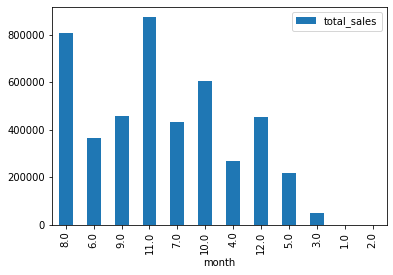

In [ ]:
total_sales=[]
months=[]
years=[]
states=[]
data=df_mlog_clean.copy()
for ye in df_mlog_clean.year.value_counts().to_frame().index:
  for mon in df_mlog_clean.month.value_counts().to_frame().index:
      years.append(ye)
      months.append(mon)
      total_sales.append(data.query("month == {0} and year == {1} ".format(mon,ye))['sMoney'].sum())
print(len(total_sales))
data_requested=pd.DataFrame({"year":years,"month":months,"total_sales":total_sales})
print(data_requested.query("year==2020").sort_values('month'))
data_requested.query("year==2020").plot(x='month',y='total_sales',kind='bar')

In [ ]:
for state in data_for_model.state.unique():
  

SyntaxError: ignored

In [ ]:
#data_for_model.query("total_sales==0")
data_for_model=data_for_model[data_for_model['total_sales'] != 0]
data_for_model

NameError: ignored

In [ ]:
data_for_model.to_csv("mlog_data_for_model.csv")

In [ ]:
any(df_mlog_clean.pay_time.isnull())

In [ ]:
df_mlog_clean.replace("None",np.nan,inplace=True)

In [ ]:

df_mlog_clean['pay_time'].value_counts()

In [ ]:
df_mlog_clean['mProvince'].value_counts()

广东省         45735
浙江省         29823
江苏省         27192
上海          26079
山东省         25154
北京          22640
四川省         14792
河南省         12861
福建省         12671
辽宁省         12512
湖北省         11699
河北省         11323
湖南省         10365
安徽省          9656
陕西省          7184
黑龙江省         7165
广西壮族自治区      7085
天津           6906
江西省          6556
重庆           6017
山西省          5952
云南省          5923
吉林省          5685
内蒙古自治区       3974
新疆维吾尔自治区     3724
贵州省          3672
甘肃省          2622
海南省          2246
宁夏回族自治区      1069
青海省           638
西藏自治区         262
Name: mProvince, dtype: int64

In [ ]:
df_mlog_clean.query("sNum ==2")

sNum  sMoney  orderMoney      mDate mProvince   day  month    year
616      2.0  168.00      168.00 2020-04-01       山东省   1.0    4.0  2020.0
923      2.0  128.00      128.00 2020-04-07       湖南省   7.0    4.0  2020.0
924      2.0  128.00      128.00 2020-04-07       广东省   7.0    4.0  2020.0
961      2.0  138.00      138.00 2020-04-08       河南省   8.0    4.0  2020.0
967      2.0  108.00      108.00 2020-04-08       河北省   8.0    4.0  2020.0
...      ...     ...         ...        ...       ...   ...    ...     ...
168221   2.0   39.90       39.90 2021-10-30       福建省  30.0   10.0  2021.0
168235   2.0   78.00       78.00 2021-10-30       四川省  30.0   10.0  2021.0
168248   2.0   78.00       78.00 2021-10-30       四川省  30.0   10.0  2021.0
168280   2.0   33.25       33.25 2021-10-30        北京  30.0   10.0  2021.0
168312   2.0   83.00       83.00 2021-10-30       河北省  30.0   10.0  2021.0

[32938 rows x 8 columns]

In [ ]:
df_mlog_clean['sNum'].value_counts()

sNum
1.0    120900
2.0     32938
3.0      9296
0.0      2087
4.0      1285
5.0       496
6.0       434
8.0       132
10.0      117
20.0       51
7.0        47
11.0       44
12.0       16
9.0        13
50.0       13
30.0       12
14.0        9
15.0        7
25.0        5
13.0        4
16.0        4
18.0        4
32.0        2
17.0        2
48.0        2
24.0        2
100.0       1
40.0        1
21.0        1
34.0        1

In [ ]:
for val in df_mlog_clean['sNum'].value_counts().to_frame().index.astype("str"):
  if ',' in val:
    print(val)

In [ ]:
df_sales_clean.head()

item_title     item_code       delivery_time  quantity  \
0         女士复合维生素软糖60粒  624879029874 2021-06-30 19:42:29        -1   
1  vitabiotics 益生菌250亿  622983431253 2021-06-30 19:41:14        -1   
2     Ultra Calcium 补钙  625497803721 2021-06-30 19:35:43        -3   
3         男士复合维生素软糖60粒  625455155425 2021-06-30 19:32:48        -1   
4     Ultra Calcium 补钙  625497803721 2021-06-30 19:31:50        -2   

   total_quantity  day  month  year  
0             165   30      6  2021  
1              72   30      6  2021  
2            6329   30      6  2021  
3            1606   30      6  2021  
4            6332   30      6  2021

### Exploration

In [ ]:
df_sales_clean=pd.read_csv("/content/sales_data_cleaned.csv",index_col=0)

In [ ]:
df_sales_clean.head()

item_title     item_code  total_quantity  ... day  month  year
0         女士复合维生素软糖60粒  624879029874             165  ...  30      6  2021
1  vitabiotics 益生菌250亿  622983431253              72  ...  30      6  2021
2     Ultra Calcium 补钙  625497803721            6329  ...  30      6  2021
3         男士复合维生素软糖60粒  625455155425            1606  ...  30      6  2021
4     Ultra Calcium 补钙  625497803721            6332  ...  30      6  2021

[5 rows x 7 columns]

In [ ]:
# plt.figure(figsize=(8,4))
# ax = sns.countplot(data = df_sales_clean, x = "item_title", color = "dodgerblue")
# ax.set_title("Item Frequency")

In [ ]:
df_mlog_clean.corr()

sNum    sMoney  orderMoney       day     month      year
sNum        1.000000  0.699684    0.682343 -0.095944  0.048595  0.027325
sMoney      0.699684  1.000000    0.934356 -0.121476  0.037121 -0.071203
orderMoney  0.682343  0.934356    1.000000 -0.107611  0.024751 -0.062783
day        -0.095944 -0.121476   -0.107611  1.000000 -0.077911 -0.091503
month       0.048595  0.037121    0.024751 -0.077911  1.000000 -0.349699
year        0.027325 -0.071203   -0.062783 -0.091503 -0.349699  1.000000

### Model

In [ ]:
!pip install lazypredict

     |████████████████████████████████| 25.9 MB 1.5 MB/s 
     |████████████████████████████████| 302 kB 61.0 MB/s 
     |████████████████████████████████| 72 kB 925 kB/s 
     |████████████████████████████████| 6.8 MB 44.1 MB/s 
     |████████████████████████████████| 248 kB 67.2 MB/s 
     |████████████████████████████████| 127.6 MB 24 kB/s 
     |████████████████████████████████| 14.5 MB 31.2 MB/s 
     |████████████████████████████████| 1.2 MB 46.3 MB/s 
     |████████████████████████████████| 269 kB 61.0 MB/s 
     |████████████████████████████████| 10.1 MB 22.7 MB/s 
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp37-cp37m-linux_x86_64.whl size=44636 sha256=26f69b60860e5853aedbe3c1f8501fbc503ffee567c1d72ced58e36d2d162a35
  Stored in directory: /root/.cache/pip/wheels/5e/03/1e/e1e954795d6f35dfc7b637fe2277bff021303bd9570ecea653
Successfully built PyYAML
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully 

In [ ]:

#data_for_model=df_mlog_clean[['orderMoney',	'mProvince','month']]
data_for_model=df_mlog_clean

In [ ]:
data_for_model=pd.read_csv("/content/mlog_data_for_model.csv",index_col=0)

In [ ]:
data_for_model.columns

Index(['cusomter', 'month', 'state', 'total_sales', 'day'], dtype='object')

In [ ]:
data_for_model_hot=pd.get_dummies(data_for_model,columns=['state'],prefix='')#state
data_for_model_hot=data_for_model_hot.drop(columns=['day'])
data_for_model_hot['month']=data_for_model_hot.month.astype("int")
#data_for_model_hot['sType']=data_for_model_hot.sType.astype("float")
data_for_model_hot.columns=data_for_model_hot.columns.str.replace("_","")
data_for_model_hot.head()

cusomter  month  totalsales  上海  云南省  内蒙古自治区  北京  吉林省  四川省  天津  ...  湖南省  \
0     82.00      8   148426.55   0    0       0   0    0    0   0  ...    0   
1     82.00      8   102214.40   0    0       0   0    0    0   0  ...    0   
2     82.00      8    91467.08   0    0       0   0    0    0   0  ...    0   
3     82.00      8   112356.13   1    0       0   0    0    0   0  ...    0   
4     82.00      8    87788.31   0    0       0   0    0    0   0  ...    0   

   甘肃省  福建省  西藏自治区  贵州省  辽宁省  重庆  陕西省  青海省  黑龙江省  
0    0    0      0    0    0   0    0    0     0  
1    0    0      0    0    0   0    0    0     0  
2    0    0      0    0    0   0    0    0     0  
3    0    0      0    0    0   0    0    0     0  
4    0    0      0    0    0   0    0    0     0  

[5 rows x 34 columns]

In [ ]:
data_for_model_hot.dtypes

cusomter      float64
month           int64
totalsales    float64
上海              uint8
云南省             uint8
内蒙古自治区          uint8
北京              uint8
吉林省             uint8
四川省             uint8
天津              uint8
宁夏回族自治区         uint8
安徽省             uint8
山东省             uint8
山西省             uint8
广东省             uint8
广西壮族自治区         uint8
新疆维吾尔自治区        uint8
江苏省             uint8
江西省             uint8
河北省             uint8
河南省             uint8
浙江省             uint8
海南省             uint8
湖北省             uint8
湖南省             uint8
甘肃省             uint8
福建省             uint8
西藏自治区           uint8
贵州省             uint8
辽宁省             uint8
重庆              uint8
陕西省             uint8
青海省             uint8
黑龙江省            uint8
dtype: object

In [ ]:
from sklearn.model_selection import train_test_split,GridSearchCV

train, test = train_test_split(data_for_model_hot, test_size = .2,random_state=42)

In [ ]:
print(len(train))
print(len(test))
print(type(train))

2976
744
<class 'pandas.core.frame.DataFrame'>


In [ ]:
from scipy import sparse

X_train = sparse.csr_matrix(train[["item_code", "month"]])
#X_train =train[["item_code", "month"]]
y_train = train["total_quantity"]

X_test = sparse.csr_matrix( test[["item_code", "month"]])
y_test =  test["total_quantity"]

In [ ]:
X_train = train[train.columns.difference(['totalsales'])]#total_sales
y_train = train["totalsales"]

X_test = test[test.columns.difference(['totalsales'])]
y_test =  test["totalsales"]

In [ ]:
X_train.shape

(2976, 33)

In [ ]:
X_train[1:2].values

array([[82.,  7.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [ ]:

input_json={'customer':'82','month':'7','state':'江苏省'}
states_list=[]
with open("states.txt","r",encoding='utf8') as f:
        states=f.read()
f.close()
for s in states.splitlines():
  states_list.append(s.replace("_",""))
input_salles=np.zeros(len(states_list)+2)
input_salles[0]=input_json['customer']
input_salles[1]=input_json['month']
for (index, item) in enumerate(states_list):
  if item == input_json['state']:
    input_salles[index+2]=1
print(input_salles.shape)
input_salles

(33,)


array([82.,  7.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [ ]:
from lazypredict.Supervised import LazyRegressor
reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None,
                    predictions=True
                    )
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

 21%|██▏       | 9/42 [00:01<00:08,  4.01it/s]

GammaRegressor model failed to execute
Some value(s) of y are out of the valid range for family GammaDistribution


100%|██████████| 42/42 [00:14<00:00,  2.97it/s]


In [ ]:
models

Adjusted R-Squared  R-Squared      RMSE  \
Model                                                                    
XGBRegressor                                 0.84       0.85   8828.05   
RandomForestRegressor                        0.75       0.76  10979.25   
HistGradientBoostingRegressor                0.75       0.76  10982.25   
LGBMRegressor                                0.75       0.76  10982.25   
BaggingRegressor                             0.74       0.75  11252.60   
GradientBoostingRegressor                    0.69       0.70  12277.44   
ExtraTreesRegressor                          0.64       0.65  13208.76   
DecisionTreeRegressor                        0.64       0.65  13208.99   
ExtraTreeRegressor                           0.37       0.40  17408.84   
KNeighborsRegressor                          0.33       0.36  17915.47   
PoissonRegressor                             0.31       0.34  18191.76   
Lars                                         0.30       0.33  18414.84   
Lasso                                        0.30       0.33  18414.87   
Ridge                                        0.30       0.33  18414.97   
RidgeCV                                      0.30       0.33  18416.21   
LassoCV                                      0.30       0.33  18416.73   
LinearRegression                             0.30       0.33  18416.86   
TransformedTargetRegressor                   0.30       0.33  18416.86   
LassoLarsCV                                  0.30       0.33  18417.31   
LarsCV                                       0.30       0.33  18417.31   
LassoLars                                    0.30       0.33  18420.28   
BayesianRidge                                0.30       0.33  18428.19   
LassoLarsIC                                  0.29       0.33  18436.40   
SGDRegressor                                 0.29       0.32  18471.97   
ElasticNet                                   0.25       0.29  18973.04   
OrthogonalMatchingPursuitCV                  0.21       0.24  19536.17   
GeneralizedLinearRegressor                   0.21       0.24  19565.36   
TweedieRegressor                             0.21       0.24  19565.36   
HuberRegressor                               0.20       0.24  19640.87   
PassiveAggressiveRegressor                   0.18       0.22  19830.57   
OrthogonalMatchingPursuit                    0.18       0.21  19911.32   
ElasticNetCV                                 0.04       0.08  21513.68   
KernelRidge                                 -0.04       0.01  22394.56   
DummyRegressor                              -0.05      -0.00  22461.50   
MLPRegressor                                -0.09      -0.04  22950.09   
NuSVR                                       -0.11      -0.06  23109.17   
RANSACRegressor                             -0.15      -0.10  23594.51   
SVR                                         -0.21      -0.16  24195.50   
LinearSVR                                   -0.32      -0.26  25255.91   
AdaBoostRegressor                           -0.48      -0.42  26740.60   
GaussianProcessRegressor                   -75.07     -71.69 191484.96   

                               Time Taken  
Model                                      
XGBRegressor                         0.48  
RandomForestRegressor                1.04  
HistGradientBoostingRegressor        0.89  
LGBMRegressor                        0.13  
BaggingRegressor                     0.12  
GradientBoostingRegressor            0.27  
ExtraTreesRegressor                  1.02  
DecisionTreeRegressor                0.08  
ExtraTreeRegressor                   0.04  
KNeighborsRegressor                  0.21  
PoissonRegressor                     0.06  
Lars                                 0.05  
Lasso                                0.20  
Ridge                                0.03  
RidgeCV                              0.06  
LassoCV                              0.24  
LinearRegression                     0.03  
TransformedT

In [ ]:
predictions

AdaBoostRegressor  BaggingRegressor  BayesianRidge  \
0             32581.34          29014.55       23042.89   
1             17234.08              0.00       -5305.51   
2             36100.80            954.76        6590.48   
3             53172.81          11647.67       11562.30   
4             21364.75           2144.94        5794.26   
..                 ...               ...            ...   
739           36545.32          25209.80       36332.27   
740           36100.80           1347.65        6732.44   
741           32581.34            619.88       10936.90   
742           36545.32              0.00       11419.13   
743           31729.29           4301.63       19407.38   

     DecisionTreeRegressor  DummyRegressor  ElasticNet  ElasticNetCV  \
0                 30067.83        12609.27    19867.51      14143.45   
1                     0.00        12609.27      261.73      10036.08   
2                  1502.54        12609.27     8411.94      11717.17   
3                  6639.65        12609.27    11856.66      12442.29   
4                  4201.51        12609.27     7910.61      11630.77   
..                     ...             ...         ...           ...   
739               22537.00        12609.27    29075.05      16082.73   
740                1116.19        12609.27     8447.80      11701.31   
741                   0.00        12609.27    11437.69      12359.92   
742                   0.00        12609.27    11795.79      12444.06   
743                6961.31        12609.27    17344.46      13610.90   

     ExtraTreeRegressor  ExtraTreesRegressor  GaussianProcessRegressor  ...  \
0              30067.83             28944.85                  45018.34  ...   
1                  0.00                 1.16                  -2978.07  ...   
2                139.00              1008.89                   3401.60  ...   
3               6910.95              9313.78                  92991.19  ...   
4               6545.41              1882.31                     92.73  ...   
..                  ...                  ...                       ...  ...   
739            22537.00             15663.95                -211380.01  ...   
740             1116.19              3055.71                   2574.09  ...   
741              159.62               212.66                  26240.21  ...   
742                0.00                 0.00                  17275.26  ...   
743             3199.00              6547.81                  19014.95  ...   

     RANSACRegressor  RandomForestRegressor    Ridge  RidgeCV  SGDRegressor  \
0            4163.89               28411.35 23311.68 23281.06      22580.28   
1            1108.14                   0.00 -5781.90 -5727.60      -6119.76   
2             570.89                 729.11  6436.72  6454.23       7172.27   
3             523.89               11537.23 11538.52 11541.22      12223.08   
4            2868.64                2085.43  5613.31  5633.94       4994.61   
..               ...                    ...      ...      ...           ...   
739         27968.89               26453.61 36948.48 36878.27      38349.06   
740          -450.11                1618.06  6590.29  6606.45       6979.72   
741         -2243.36                 227.19 10894.99 10899.76       9993.92   
742          4217.89                   0.00 11386.78 11390.47      11835.72   
743          3963.89                6881.36 19581.63 19561.78      18654.64   

        SVR  TransformedTargetRegressor  TweedieRegressor  XGBRegressor  \
0   3938.60                    23351.64          18103.22      20625.38   
1   3838.58                    -5996.36           3314.64        -88.46   
2   3889.60                     6359.64           9429.37      -2365.85   
3   3917.49                    11575.64          12029.70      15048.68   
4   3909.84                     5555.64           9071.27       2098.71   
..      ...                         ...               ...           ...   
739 3949

In [ ]:

#xg_model.load_model("/content/Sales_model.sav")
import joblib
#save model
filename="Sales_model.sav"
joblib.dump(xg_model, filename) 
#booster.save_model('model.json')
#load saved model
xgb = joblib.load(filename)

[17:57:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score,mean_squared_error,mean_absolute_error


# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
xg_model = xgb.XGBRegressor(learning_rate = 0.75)
xg_model.fit(X_train, y_train)
xg_train_score=xg_model.score(X_train,y_train)
xg_test_score=xg_model.score(X_test,y_test)

xg_train_pred = xg_model.predict(X_train) 
xg_test_pred = xg_model.predict(X_test) 


In [ ]:

print(np.sqrt(metrics.mean_squared_error(y_train, xg_train_pred)))
print(metrics.r2_score(y_train, xg_train_pred))
print(metrics.mean_absolute_error(y_train, xg_train_pred))
print(xg_train_score)
print("...............................................")
print(np.sqrt(metrics.mean_squared_error(y_test, xg_test_pred)))
print(metrics.r2_score(y_test, xg_test_pred))
print(metrics.mean_absolute_error(y_test, xg_test_pred))
print(xg_test_score)

1747.4800494494302
0.9939396186291395
1185.9079027290625
0.9939396186291395
...............................................
9459.746056585329
0.822590555556385
4892.748646031861
0.822590555556385


In [ ]:
xg_model.save_model("Sales_model_basedon_customer.txt")

In [ ]:
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

In [ ]:
def objective(space):
    clf=xgb.XGBRegressor(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train, y_train
            #,eval_set=evaluation,eval_metric =mean_absolute_error,
            ,early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [ ]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

[17:31:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
  0%|          | 0/100 [00:00<?, ?it/s, best loss: ?]


IndexError: ignored

In [ ]:
parameters = {'learning_rate':np.arange(0.001,0.2,0.001)}
clf = GridSearchCV(xg_model, space)
gs=clf.fit(X_train,y_train)

ValueError: ignored

In [ ]:
gs.best_params_

{'learning_rate': 0.187}

In [ ]:
gs.best_score_

0.6956862619918323

In [ ]:
import pickle 

filename = 'Xgboost_Forcast.sav'
pickle.dump(xg_model, open(filename, 'wb'))

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


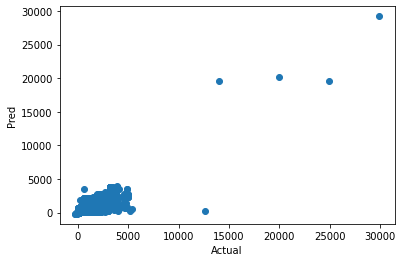

None

In [ ]:
plt.figure()
plt.scatter(y_train,xg_train_pred)
plt.xlabel("Actual")
plt.ylabel("Pred")
display(plt.show())

In [ ]:
from sklearn.linear_model import LinearRegression,HuberRegressor

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_train_score=lr_model.score(X_train,y_train)
lr_test_score=lr_model.score(X_test,y_test)

lr_train_pred = lr_model.predict(X_train) 
lr_test_pred = lr_model.predict(X_test) 
print(np.sqrt(metrics.mean_squared_error(y_train, lr_train_pred)))
print(metrics.r2_score(y_train, lr_train_pred))
print(metrics.mean_absolute_error(y_train, lr_train_pred))
print(lr_train_score)
print("...............................................")
print(np.sqrt(metrics.mean_squared_error(y_test, lr_test_pred)))
print(metrics.r2_score(y_test, lr_test_pred))
print(metrics.mean_absolute_error(y_test, lr_test_pred))
print(lr_test_score)

18830.728975184997
0.29626400089904525
11334.822989628317
0.29626400089904525
...............................................
18414.840439093616
0.32771456871911464
11347.19611307149
0.32771456871911464


In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)
dt_train_score=dt_model.score(X_train,y_train)
dt_test_score=dt_model.score(X_test,y_test)

dt_train_pred = dt_model.predict(X_train) 
dt_test_pred = dt_model.predict(X_test) 
print(np.sqrt(metrics.mean_squared_error(y_train, dt_train_pred)))
print(metrics.r2_score(y_train, dt_train_pred))
print(metrics.mean_absolute_error(y_train, dt_train_pred))
print(dt_train_score)
print("...............................................")
print(np.sqrt(metrics.mean_squared_error(y_test, dt_test_pred)))
print(metrics.r2_score(y_test, dt_test_pred))
print(metrics.mean_absolute_error(y_test, dt_test_pred))
print(dt_test_score)

0.0
1.0
0.0
1.0
...............................................
12875.788290376502
0.6713259365101878
5557.194879032258
0.6713259365101878


#ARMIA model

In [ ]:
df_mlog_clean[['mDate','orderMoney']]

sNum  sMoney  orderMoney      mDate mProvince   day  month    year
0        1.0    99.0       99.00 2020-03-26       广东省  26.0    3.0  2020.0
1        1.0    99.0       99.00 2020-03-26      黑龙江省  26.0    3.0  2020.0
2        1.0    99.0       99.00 2020-03-26       山东省  26.0    3.0  2020.0
3        1.0    99.0       99.00 2020-03-26       江苏省  26.0    3.0  2020.0
4        1.0    99.0       99.00 2020-03-26       河南省  26.0    3.0  2020.0
...      ...     ...         ...        ...       ...   ...    ...     ...
183590   0.0     0.0     -243.74 2021-12-12       山东省  12.0   12.0  2021.0
183591   0.0     0.0      -89.00 2021-12-09       湖南省   9.0   12.0  2021.0
183592   0.0     0.0      -17.50 2021-12-03       河北省   3.0   12.0  2021.0
183593   0.0     0.0      -89.00 2021-12-09       江苏省   9.0   12.0  2021.0
183594   0.0     0.0      -89.00 2021-12-09       湖北省   9.0   12.0  2021.0

[181759 rows x 8 columns]

In [ ]:
data=df_mlog_clean.copy()
data.query("month == 4 and year == 2020")['orderMoney']

511       99.00
512      109.00
513      109.00
514      109.00
515      109.00
          ...  
4673     -72.00
4674     -20.00
4675      -5.00
5098     -63.24
37752     -5.00
Name: orderMoney, Length: 3289, dtype: float64

In [ ]:
data_for_model.describe()

year      month          sales   day
count    24.000000  24.000000      24.000000  24.0
mean   2020.500000   6.500000  441103.331667   1.0
std       0.510754   3.526299  225348.561076   0.0
min    2020.000000   1.000000       0.000000   1.0
25%    2020.000000   3.750000  361644.682500   1.0
50%    2020.500000   6.500000  455227.240000   1.0
75%    2021.000000   9.250000  562692.447500   1.0
max    2021.000000  12.000000  841328.760000   1.0

In [ ]:
total_sales=[]
months=[]
years=[]
data=df_mlog_clean.copy()
for ye in df_mlog_clean.year.value_counts().to_frame().index:
  for mon in df_mlog_clean.month.value_counts().to_frame().index:
    years.append(int(ye))
    months.append(int(mon))
    total_sales.append(data.query("month == {0} and year == {1}".format(mon,ye))['orderMoney'].sum())
print(len(total_sales))
data_for_model=pd.DataFrame({"year":years,"month":months,"sales":total_sales})
data_for_model["day"]=int(1)
data_for_model['day']=data_for_model['day'].astype(int)
data_for_model['month']=data_for_model['month'].astype(int)
data_for_model['year']=data_for_model['year'].astype(int)
data_for_model['day']=data_for_model['day'].astype(str)
data_for_model['month']=data_for_model['month'].astype(str)
data_for_model['year']=data_for_model['year'].astype(str)
import datetime
data_for_model['Date']=data_for_model['month']+"-"+data_for_model['day']+"-"+data_for_model['year']
data_for_model['Date']=pd.to_datetime(data_for_model["Date"])
data_for_model.sort_values(by=['Date'], inplace=True, ascending=False)
data_for_model

24
   year month      sales day
0  2021     8  461103.62   1
1  2021     6  811421.89   1
2  2021     9  618943.80   1
3  2021    11  579197.99   1
4  2021     7  457213.39   1


year month      sales day       Date
7   2021    12  358257.57   1 2021-12-01
3   2021    11  579197.99   1 2021-11-01
5   2021    10  498589.74   1 2021-10-01
2   2021     9  618943.80   1 2021-09-01
0   2021     8  461103.62   1 2021-08-01
4   2021     7  457213.39   1 2021-07-01
1   2021     6  811421.89   1 2021-06-01
8   2021     5  449768.90   1 2021-05-01
6   2021     4  581645.93   1 2021-04-01
9   2021     3  557190.60   1 2021-03-01
11  2021     2  366393.79   1 2021-02-01
10  2021     1  490078.92   1 2021-01-01
19  2020    12  444528.44   1 2020-12-01
15  2020    11  841328.76   1 2020-11-01
17  2020    10  496902.71   1 2020-10-01
14  2020     9  453241.09   1 2020-09-01
12  2020     8  803618.53   1 2020-08-01
16  2020     7  428971.97   1 2020-07-01
13  2020     6  362773.72   1 2020-06-01
20  2020     5  207960.72   1 2020-05-01
18  2020     4  267887.88   1 2020-04-01
21  2020     3   49460.00   1 2020-03-01
23  2020     2       0.00   1 2020-02-01
22  2020     1       0.00   1 2020-01-01

In [ ]:
def get_diff(data):
    data['sales_diff'] = data.sales.diff()
    data = data.dropna()
    
    data.to_csv('stationary_df.csv')
    return data
monthly_df=data_for_model[['Date','sales']]
stationary_df = get_diff(monthly_df)

In [ ]:
#create dataframe for transformation from time series to supervised
def generate_supervised(data):
    supervised_df = data.copy()
    
    #create column for each lag
    for i in range(1,13):
        col_name = 'lag_' + str(i)
        supervised_df[col_name] = supervised_df['sales_diff'].shift(i)
    
    #drop null values
    supervised_df = supervised_df.dropna().reset_index(drop=True)
    
    supervised_df.to_csv('model_df.csv', index=False)
    
    return supervised_df
model_df = generate_supervised(stationary_df)
model_df

Date      sales  sales_diff  ...     lag_10     lag_11     lag_12
0  2020-11-01  841328.76   396800.32  ...  120354.06  -80608.25  220940.42
1  2020-10-01  496902.71  -344426.05  ... -157840.18  120354.06  -80608.25
2  2020-09-01  453241.09   -43661.62  ...   -3890.23 -157840.18  120354.06
3  2020-08-01  803618.53   350377.44  ...  354208.50   -3890.23 -157840.18
4  2020-07-01  428971.97  -374646.56  ... -361652.99  354208.50   -3890.23
5  2020-06-01  362773.72   -66198.25  ...  131877.03 -361652.99  354208.50
6  2020-05-01  207960.72  -154813.00  ...  -24455.33  131877.03 -361652.99
7  2020-04-01  267887.88    59927.16  ... -190796.81  -24455.33  131877.03
8  2020-03-01   49460.00  -218427.88  ...  123685.13 -190796.81  -24455.33
9  2020-02-01       0.00   -49460.00  ...  -45550.48  123685.13 -190796.81
10 2020-01-01       0.00        0.00  ...  396800.32  -45550.48  123685.13

[11 rows x 15 columns]

In [ ]:
def generate_arima_data(data):
    dt_data = data.set_index('Date').drop('sales', axis=1)
    dt_data.dropna(axis=0)
    
    dt_data.to_csv('arima_df.csv')
    
    return dt_data
datetime_df = generate_arima_data(stationary_df)
datetime_df

sales_diff
Date                  
2021-11-01   220940.42
2021-10-01   -80608.25
2021-09-01   120354.06
2021-08-01  -157840.18
2021-07-01    -3890.23
2021-06-01   354208.50
2021-05-01  -361652.99
2021-04-01   131877.03
2021-03-01   -24455.33
2021-02-01  -190796.81
2021-01-01   123685.13
2020-12-01   -45550.48
2020-11-01   396800.32
2020-10-01  -344426.05
2020-09-01   -43661.62
2020-08-01   350377.44
2020-07-01  -374646.56
2020-06-01   -66198.25
2020-05-01  -154813.00
2020-04-01    59927.16
2020-03-01  -218427.88
2020-02-01   -49460.00
2020-01-01        0.00

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import pickle

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
def load_data():
    return pd.read_csv('arima_df.csv').set_index('Date')

ts_data = load_data()
ts_data.index = pd.to_datetime(ts_data.index)

def get_scores(data):
    
    model_scores = {}
    
    rmse = np.sqrt(mean_squared_error(data.sales_diff[-12:], data.forecast[-12:]))
    mae = mean_absolute_error(data.sales_diff[-12:], data.forecast[-12:])
    r2 = r2_score(data.sales_diff[-12:], data.forecast[-12:])
    model_scores['ARIMA'] = [rmse, mae, r2]
    
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R2 Score: {r2}")
    
    pickle.dump(model_scores, open( "arima_model_scores.p", "wb" ))

In [ ]:
def sarimax_model(data):
    
    # Model
    sar = sm.tsa.statespace.SARIMAX(ts_data.sales_diff, order=(12,0,0), seasonal_order=(0,1,0,12), trend='c').fit()

    # Predictions
    start, end, dynamic = 40, 100, 7
    data['forecast'] = sar.predict(start=start, end=end, dynamic=dynamic) 
    pred_df = data.forecast[start+dynamic:end]
    
    data[['sales_diff', 'forecast']].plot(color=['mediumblue', 'Red'])
    
    get_scores(data)

    return sar, data, pred_df

sar, ts_data, predictions = sarimax_model(ts_data)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1MS will be used.
  % freq, ValueWarning)


ValueError: ignored

In [ ]:

with open("states.txt","w") as f:
  for state in X_train.columns.difference(['month']):
    f.write(state+"\n")
f.close()

In [ ]:
states_list=[]
with open("states.txt","r") as f:
    states=f.read()
    f.close()
for s in states.splitlines():
  states_list.append(s.replace("_",""))
print(states_list)

['上海', '云南省', '内蒙古自治区', '北京', '吉林省', '四川省', '天津', '宁夏回族自治区', '安徽省', '山东省', '山西省', '广东省', '广西壮族自治区', '新疆维吾尔自治区', '江苏省', '江西省', '河北省', '河南省', '浙江省', '海南省', '湖北省', '湖南省', '甘肃省', '福建省', '西藏自治区', '贵州省', '辽宁省', '重庆', '陕西省', '青海省', '黑龙江省']


In [ ]:
import numpy as np
import flask
import sklearn
from flask import Flask, request, jsonify
import pickle
def testpost(js,model1):
     #input_json = request.get_json(force=True)
     input_json=js
     if input_json['type']=='Sales' and input_json['state'] in states_list and input_json['month'] in range(1,13):

         input_salles=np.zeros(len(states_list)+1)
         input_salles[len(states_list)]=input_json['month']
         for (index, item) in enumerate(states_list):

             if item == input_json['state']:

                 input_salles[index]=1
             else:
                 text="there is no state match"
         prediction1=model1.predict(input_salles.reshape(1,-1))
         dictToReturn1 = {'SalesForcast':prediction1[0]}
         print(dictToReturn1)
     elif input_json['type']=='Items':
       input_items=np.array([input_json['item_code'],input_json['month']])
       prediction2=model2.predict(input_items.reshape(1,-1))
       dictToReturn2 = {'ItemsCountForcast':int(prediction2)}
       print(dictToReturn2)

      

###**Test1 Sales**

In [ ]:
file_name1="/content/Liner_Forcast.sav"
model1=pickle.load(open(file_name1, 'rb'))
js1={"type":"Sales","state":"吉林省","month":10}
testpost(js1,model1)

{'SalesForcast': 8671.07113859864}


###**Test2 Items**

In [ ]:
import xgboost as xgb
import xgboost
print(xgboost.__version__)
file_name1="/content/Items_model.sav"
model2=pickle.load(open(file_name1, 'rb'))
js2={"type":"Items","item_code":"624879029874","month":10}
testpost(js,model2)

In [ ]:
import numpy as np
import sklearn
from flask import Flask, request, jsonify
import pickle
app = Flask(__name__)
file_name1="Sales_model.sav"
file_name2="Items_model.sav"
model1=pickle.load(open(file_name1, 'rb'))
#model2=pickle.load(open(file_name2, 'rb'))
states_list=[]
with open("states.txt","r") as f:
    states=f.read()
    f.close()
for s in states.splitlines():
  states_list.append(s.replace("_",""))


@app.route('/')
def hello_world():
    return 'This API is for Sales and Items Forcasting!'
#{[type:Sales/Items,month:5]}
#sales :
#state provience
#month
#items:
#item_code
#month
@app.route('/post', methods=["POST"])
def testpost():
     try:
        input_json = request.get_json(force=True)
        if input_json['type']=='Sales' and input_json['state'] in states_list and input_json['month'] in range(1,13):

            input_salles=np.zeros(len(states_list)+1)
            input_salles[len(states_list)]=input_json['month']
            for (index, item) in enumerate(states_list):

                if item == input_json['state']:

                    input_salles[index]=1
                else:
                    text="there is no state match"
                    dictToReturn_err = {'Error':text}
                    return jsonify(dictToReturn_err)
            
            print(input_salles)
            prediction1=model1.predict(input_salles.reshape(1,-1))
            dictToReturn1 = {'SalesForcast':prediction1}
            return jsonify(dictToReturn1)
        elif input_json['type']=='Items':

            input_items=np.array([input_json['item_code'],input_json['month']])
            prediction2=model2.predict(input_items.reshape(1,-1))
            dictToReturn2 = {'ItemsCountForcast':int(prediction2)}
            return jsonify(dictToReturn2)
        else:
            text_tot="there is a problem in the value in the type key or in other parameters ,please check the notes provided about using the API"
            dictToReturn_err_tot = {'Error':text_tot}
            return jsonify(dictToReturn_err_tot)
     except NameError:
         dictToReturn_err_tot = {'Error':"Theres is a problem in the request or the JSON format and the exception caught is"+NameError}
         return jsonify(dictToReturn_err_tot)
         
  



Exception ignored in: <function Booster.__del__ at 0x7f19cbc99050>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/xgboost/core.py", line 957, in __del__
    if self.handle is not None:
AttributeError: 'Booster' object has no attribute 'handle'
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:333: UserWarning: Trying to unpickle estimator LinearRegression from version 0.23.1 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor

import keras
from keras.layers import Dense
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.layers import LSTM
from sklearn.model_selection import KFold, cross_val_score, train_test_split

In [ ]:
model_df = pd.read_csv('model_df.csv')

def tts(data):
    data = data.drop(['sales','Date'],axis=1)
    train, test = data[0:-2].values, data[-2:].values
    
    return train, test

train, test = tts(model_df)
train.shape

(9, 13)

In [ ]:
test.shape

(2, 13)

In [ ]:
def scale_data(train_set, test_set):
    #apply Min Max Scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train_set)
    
    # reshape training set
    train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
    train_set_scaled = scaler.transform(train_set)
    
    # reshape test set
    test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
    test_set_scaled = scaler.transform(test_set)
    
    X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1].ravel()
    X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1].ravel()
    
    return X_train, y_train, X_test, y_test, scaler

X_train, y_train, X_test, y_test, scaler_object = scale_data(train, test)
y_train.shape

(9,)

In [ ]:
def undo_scaling(y_pred, x_test, scaler_obj, lstm=False):  
    #reshape y_pred
    y_pred = y_pred.reshape(y_pred.shape[0], 1, 1)
    
    if not lstm:
        x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])
    
    #rebuild test set for inverse transform
    pred_test_set = []
    for index in range(0,len(y_pred)):
        pred_test_set.append(np.concatenate([y_pred[index],x_test[index]],axis=1))
        
    #reshape pred_test_set
    pred_test_set = np.array(pred_test_set)
    pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])
    
    #inverse transform
    pred_test_set_inverted = scaler_obj.inverse_transform(pred_test_set)
    
    return pred_test_set_inverted
def load_original_df():
    origin_data=data_for_model[['Date','sales']]
    return origin_data
                          
def predict_df(unscaled_predictions, original_df):
    #create dataframe that shows the predicted sales
    result_list = []
    sales_dates = list(original_df[-13:].Date)
    act_sales = list(original_df[-13:].sales)
    
    for index in range(0,len(unscaled_predictions)):
        result_dict = {}
        result_dict['pred_value'] = int(unscaled_predictions[index][0] + act_sales[index])
        result_dict['Date'] = sales_dates[index+1]
        result_list.append(result_dict)
        
    df_result = pd.DataFrame(result_list)
    
    return df_result

In [ ]:

model_scores = {}

def get_scores(unscaled_df, original_df, model_name):
    rmse = np.sqrt(mean_squared_error(original_df.sales[-2:], unscaled_df.pred_value[-2:]))
    mae = mean_absolute_error(original_df.sales[-2:], unscaled_df.pred_value[-2:])
    r2 = r2_score(original_df.sales[-2:], unscaled_df.pred_value[-2:])
    model_scores[model_name] = [rmse, mae, r2]

    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R2 Score: {r2}")

In [ ]:
def plot_results(results, original_df, model_name):

    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(original_df.Date, original_df.sales, data=original_df, ax=ax, 
                 label='Original', color='mediumblue')
    sns.lineplot(results.Date, results.pred_value, data=results, ax=ax, 
                 label='Predicted', color='Red')
    
    ax.set(xlabel = "Date",
           ylabel = "Sales",
           title = f"{model_name} Sales Forecasting Prediction")
    
    ax.legend()
    
    sns.despine()
    
    plt.savefig(f'model_output/{model_name}_forecast.png')
def run_model(train_data, test_data, model, model_name):
    
    X_train, y_train, X_test, y_test, scaler_object = scale_data(train_data, test_data)
    
    mod = model
    mod.fit(X_train, y_train)
    predictions = mod.predict(X_test)
    
    # Undo scaling to compare predictions against original data
    original_df = load_original_df()
    unscaled = undo_scaling(predictions, X_test, scaler_object)
    unscaled_df = predict_df(unscaled, original_df)
      
    get_scores(unscaled_df, original_df, model_name)
    
    plot_results(unscaled_df, original_df, model_name)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


RMSE: 842065.876399525
MAE: 714622.5
R2 Score: 0.0


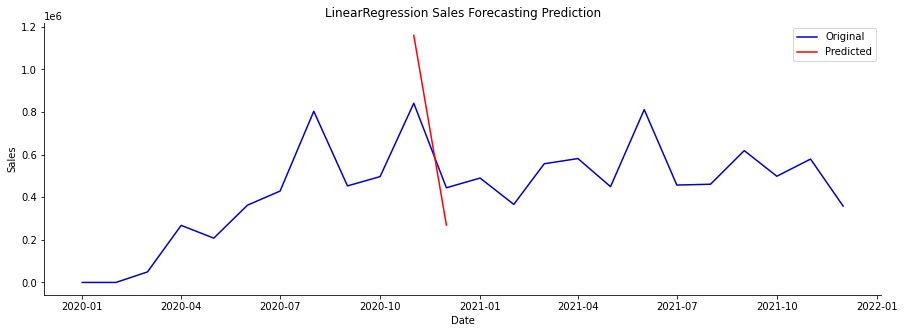

In [ ]:
run_model(train, test, LinearRegression(), 'LinearRegression')

RMSE: 518110.84612175415
MAE: 491030.0
R2 Score: 0.0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


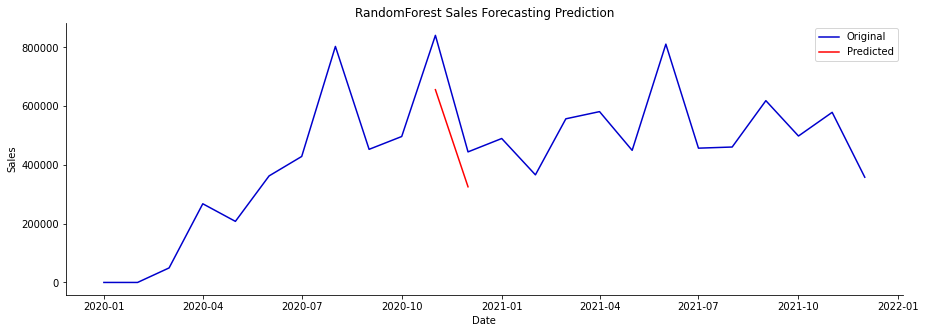

In [ ]:
run_model(train, test, RandomForestRegressor(n_estimators=100, max_depth=20), 
          'RandomForest')

RMSE: 652751.7962732848
MAE: 617047.0
R2 Score: 0.0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


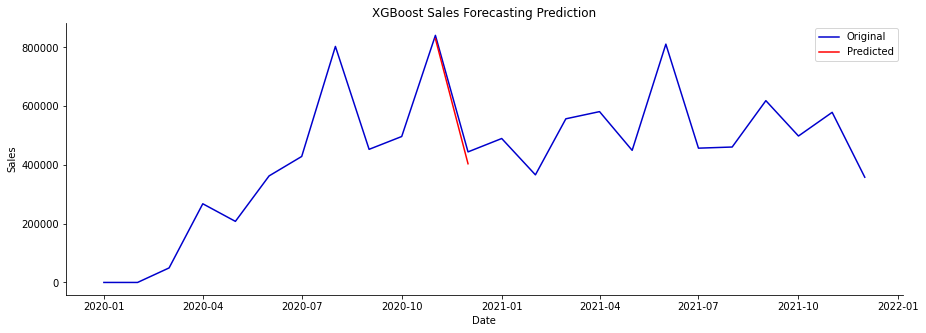

In [ ]:
run_model(train, test, XGBRegressor( n_estimators=100, 
                                    learning_rate=0.2, 
                                    objective='reg:squarederror'), 'XGBoost')

In [ ]:
def lstm_model(train_data, test_data):
    
    X_train, y_train, X_test, y_test, scaler_object = scale_data(train_data, test_data)
    
    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
   
    model = Sequential()
    model.add(LSTM(4, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), 
                   stateful=True))
    model.add(Dense(1))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train, epochs=200, batch_size=1, verbose=1, 
              shuffle=False)
    predictions = model.predict(X_test,batch_size=1)
    
    original_df = load_original_df()
    unscaled = undo_scaling(predictions, X_test, scaler_object, lstm=True)
    unscaled_df = predict_df(unscaled, original_df)
    
    get_scores(unscaled_df, original_df, 'LSTM')
    
    plot_results(unscaled_df, original_df, 'LSTM')

Epoch 1/200
9/9 [==============================] - 2s 3ms/step - loss: 0.5683
Epoch 2/200
9/9 [==============================] - 0s 2ms/step - loss: 0.5556
Epoch 3/200
9/9 [==============================] - 0s 3ms/step - loss: 0.5384
Epoch 4/200
9/9 [==============================] - 0s 2ms/step - loss: 0.5215
Epoch 5/200
9/9 [==============================] - 0s 2ms/step - loss: 0.5058
Epoch 6/200
9/9 [==============================] - 0s 2ms/step - loss: 0.4912
Epoch 7/200
9/9 [==============================] - 0s 2ms/step - loss: 0.4776
Epoch 8/200
9/9 [==============================] - 0s 2ms/step - loss: 0.4648
Epoch 9/200
9/9 [==============================] - 0s 2ms/step - loss: 0.4528
Epoch 10/200
9/9 [==============================] - 0s 2ms/step - loss: 0.4413
Epoch 11/200
9/9 [==============================] - 0s 2ms/step - loss: 0.4304
Epoch 12/200
9/9 [==============================] - 0s 3ms/step - loss: 0.4199
Epoch 13/200
9/9 [==============================] - 0s 3ms/st

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


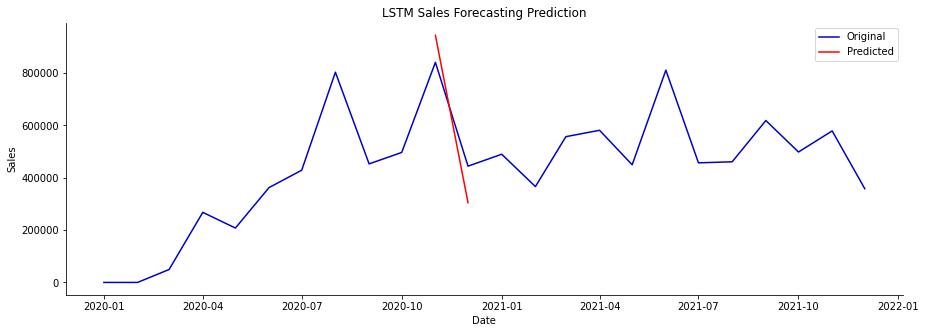

In [ ]:
lstm_model(train, test)

In [ ]:
print(xgb.__version__)
file_name1="/content/Xgboost_Forcast.sav"
model1=pickle.load(open(file_name1, 'rb'))

0.90
[02:29:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
states_list=[]
with open("states.txt","r",encoding='utf8') as f:
    states=f.read()
    f.close()
for s in states.splitlines():
  states_list.append(s.replace("_",""))
print(states_list)

['上海', '云南省', '内蒙古自治区', '北京', '吉林省', '四川省', '天津', '宁夏回族自治区', '安徽省', '山东省', '山西省', '广东省', '广西壮族自治区', '新疆维吾尔自治区', '江苏省', '江西省', '河北省', '河南省', '浙江省', '海南省', '湖北省', '湖南省', '甘肃省', '福建省', '西藏自治区', '贵州省', '辽宁省', '重庆', '陕西省', '青海省', '黑龙江省']


In [ ]:
()